In [1]:
# Install required libraries
!pip install fairlearn scikit-learn pandas matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 7.0 MB/s eta 0:00:00


In [2]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference
from fairlearn.postprocessing import ThresholdOptimizer

In [3]:

np.random.seed(42)
data_size = 1000
df = pd.DataFrame({
    'Gender': np.random.choice(['Male', 'Female'], size=data_size),
    'Age': np.random.randint(20, 60, size=data_size),
    'Income': np.random.randint(20000, 100000, size=data_size),
    'Loan_Amount': np.random.randint(5000, 50000, size=data_size),
    'Credit_Score': np.random.randint(300, 850, size=data_size),
    'Approved': np.random.choice([0, 1], size=data_size)  # Target variable (0: Rejected, 1: Approved)
})

In [4]:
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])  # Convert 'Male'/'Female' to 0/1
X = df.drop(columns=['Approved'])  # Features
y = df['Approved']  # Target


In [5]:
scaler = StandardScaler()
X[['Age', 'Income', 'Loan_Amount', 'Credit_Score']] = scaler.fit_transform(X[['Age', 'Income', 'Loan_Amount', 'Credit_Score']])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [8]:
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Model Accuracy: 0.435
              precision    recall  f1-score   support

           0       0.43      0.37      0.40       100
           1       0.44      0.50      0.47       100

    accuracy                           0.43       200
   macro avg       0.43      0.43      0.43       200
weighted avg       0.43      0.43      0.43       200



In [9]:
sensitive_feature = X_test['Gender']

In [10]:
metric_frame = MetricFrame(
    metrics={"Selection Rate": selection_rate},
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_feature
)
print("\nSelection Rate per Gender:")
print(metric_frame.by_group)




Selection Rate per Gender:
        Selection Rate
Gender                
0             0.476190
1             0.663158


In [11]:
metric_frame = MetricFrame(
    metrics={"Selection Rate": selection_rate},
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_feature
)
print("\nSelection Rate per Gender:")
print(metric_frame.by_group)




Selection Rate per Gender:
        Selection Rate
Gender                
0             0.476190
1             0.663158


In [12]:
dpd = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_feature)
print("\nDemographic Parity Difference:", dpd)



Demographic Parity Difference: 0.1869674185463659


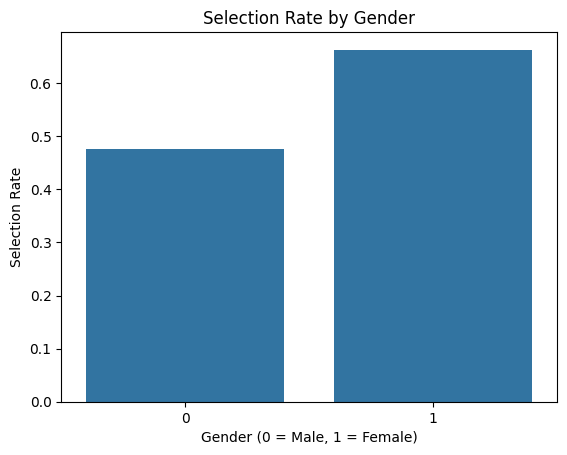

In [14]:
sns.barplot(x=metric_frame.by_group.index, y=metric_frame.by_group["Selection Rate"].values)
plt.title("Selection Rate by Gender")
plt.xlabel("Gender (0 = Male, 1 = Female)")
plt.ylabel("Selection Rate")
plt.show()


In [15]:
optimizer = ThresholdOptimizer(
    estimator=model,
    constraints="demographic_parity",
    prefit=True
)
optimizer.fit(X_train, y_train, sensitive_features=X_train['Gender'])
y_pred_fair = optimizer.predict(X_test, sensitive_features=X_test['Gender'])

In [16]:
dpd_fair = demographic_parity_difference(y_test, y_pred_fair, sensitive_features=sensitive_feature)
print("\nDemographic Parity Difference After Mitigation:", dpd_fair)


Demographic Parity Difference After Mitigation: 0.05263157894736836
